<a href="https://colab.research.google.com/github/xuebingwu/predict-splice-sites/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Xuebing Wu lab @ Columbia](https://xuebingwu.github.io/)  |     [GitHub repository](https://github.com/xuebingwu/splice-site-prediction-with-pangolin) 

---

# <font color='MediumSlateBlue '> Predict 5' and 3' splice sites from a single sequence using [Pangolin](https://doi.org/10.1186/s13059-022-02664-4)</font> 

---





Sample Output




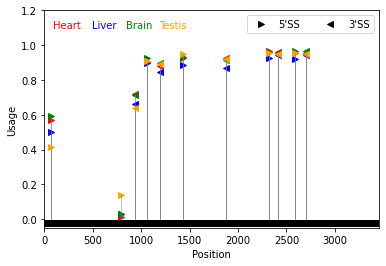

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



Predicted splice sites

Position	Sequence	Type	Heart	Liver	Brain	Testis
-----------------------------------------------------------------------
73 	 CCCGCCGCCAGgtaagcccg	5'SS	0.57	0.503	0.59	0.415
791 	 TGCCTTTTATGgtaataacg	5'SS	0.013	0.032	0.028	0.14
934 	 attctcgcagCTCACCATGG	3'SS	0.72	0.66	0.711	0.64
1062 	 CCAGGCACCAGgtaggggag	5'SS	0.906	0.897	0.926	0.909
1197 	 tccttcccagGGCGTGATGG	3'SS	0.88	0.845	0.898	0.892
1436 	 AGATGACCCAGgtgagtggc	5'SS	0.927	0.888	0.93	0.947
1878 	 tgccttacagATCATGTTTG	3'SS	0.924	0.871	0.912	0.921
2316 	 TTCCTTCCTGGgtgagtgga	5'SS	0.968	0.929	0.961	0.954
2412 	 tccctctcagGCATGGAGTC	3'SS	0.962	0.944	0.957	0.95
2593 	 TGAAGATCAAGgtgggtgtc	5'SS	0.957	0.92	0.969	0.956
2706 	 ccctcctcagATCATTGCTC	3'SS	0.955	0.943	0.965	0.949

Columns:
Position:	Site position in the sequence
Sequence:	20-nt junction sequence. Intron-lower case; Exon-upper case
Type    :	5' splice site (5'SS), 3' splice site (3'SS), or Undetermined, or Noncanonical
Scores  :	Site usage or P(splice

In [ ]:
##@title Analyze your sequence

# scripts from custom_usage.py from the Pangolin package

import os
from matplotlib import pylab
import matplotlib.lines as mlines
from google.colab import files
import datetime
import re


class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

########## input 
SEQUENCE = "Enter your sequence or select a sample sequence (default: ACTB pre-mRNA)"#@param ["ACTB pre-mRNA", "GAPDH pre-mRNA", "EGFP + CENPB 3' UTR reporter"] {allow-input: true}

#@markdown - To run: click `Runtime` -> `Run all` in the menu bar, or click the triangle play/run button on the left
#@markdown - Input format: raw sequence (A/C/G/T/U only); can paste a multi-line sequence from a FASTA file (without the header) 
#@markdown - More accurate to use full-length transcript sequence (model scores each 10kb window)
#@markdown - Can also run on a short sequence 

seq = SEQUENCE

output="Sample Output"

if seq == "ACTB pre-mRNA":
  seq = "CGAGACCGCGTCCGCCCCGCGAGCACAGAGCCTCGCCTTTGCCGATCCGCCGCCCGTCCACACCCGCCGCCAGGTAAGCCCGGCCAGCCGACCGGGGCAGGCGGCTCACGGCCCGGCCGCAGGCGGCCGCGGCCCCTTCGCCCGTGCAGAGCCGCCGTCTGGGCCGCAGCGGGGGGCGCATGGGGGGGGAACCGGACCGCCGTGGGGGGCGCGGGAGAAGCCCCTGGGCCTCCGGAGATGGGGGACACCCCACGCCAGTTCGGAGGCGCGAGGCCGCGCTCGGGAGGCGCGCTCCGGGGGTGCCGCTCTCGGGGCGGGGGCAACCGGCGGGGTCTTTGTCTGAGCCGGGCTCTTGCCAATGGGGATCGCAGGGTGGGCGCGGCGGAGCCCCCGCCAGGCCCGGTGGGGGCTGGGGCGCCATTGCGCGTGCGCGCTGGTCCTTTGGGCGCTAACTGCGTGCGCGCTGGGAATTGGCGCTAATTGCGCGTGCGCGCTGGGACTCAAGGCGCTAACTGCGCGTGCGTTCTGGGGCCCGGGGTGCCGCGGCCTGGGCTGGGGCGAAGGCGGGCTCGGCCGGAAGGGGTGGGGTCGCCGCGGCTCCCGGGCGCTTGCGCGCACTTCCTGCCCGAGCCGCTGGCCGCCCGAGGGTGTGGCCGCTGCGTGCGCGCGCGCCGACCCGGCGCTGTTTGAACCGGGCGGAGGCGGGGCTGGCGCCCGGTTGGGAGGGGGTTGGGGCCTGGCTTCCTGCCGCGCGCCGCGGGGACGCCTCCGACCAGTGTTTGCCTTTTATGGTAATAACGCGGCCGGCCCGGCTTCCTTTGTCCCCAATCTGGGCGCGCGCCGGCGCCCCCTGGCGGCCTAAGGACTCGGCGCGCCGGAAGTGGCCAGGGCGGGGGCGACCTCGGCTCACAGCGCGCCCGGCTATTCTCGCAGCTCACCATGGATGATGATATCGCCGCGCTCGTCGTCGACAACGGCTCCGGCATGTGCAAGGCCGGCTTCGCGGGCGACGATGCCCCCCGGGCCGTCTTCCCCTCCATCGTGGGGCGCCCCAGGCACCAGGTAGGGGAGCTGGCTGGGTGGGGCAGCCCCGGGAGCGGGCGGGAGGCAAGGGCGCTTTCTCTGCACAGGAGCCTCCCGGTTTCCGGGGTGGGGGCTGCGCCCGTGCTCAGGGCTTCTTGTCCTTTCCTTCCCAGGGCGTGATGGTGGGCATGGGTCAGAAGGATTCCTATGTGGGCGACGAGGCCCAGAGCAAGAGAGGCATCCTCACCCTGAAGTACCCCATCGAGCACGGCATCGTCACCAACTGGGACGACATGGAGAAAATCTGGCACCACACCTTCTACAATGAGCTGCGTGTGGCTCCCGAGGAGCACCCCGTGCTGCTGACCGAGGCCCCCCTGAACCCCAAGGCCAACCGCGAGAAGATGACCCAGGTGAGTGGCCCGCTACCTCTTCTGGTGGCCGCCTCCCTCCTTCCTGGCCTCCCGGAGCTGCGCCCTTTCTCACTGGTTCTCTCTTCTGCCGTTTTCCGTAGGACTCTCTTCTCTGACCTGAGTCTCCTTTGGAACTCTGCAGGTTCTATTTGCTTTTTCCCAGATGAGCTCTTTTTCTGGTGTTTGTCTCTCTGACTAGGTGTCTAAGACAGTGTTGTGGGTGTAGGTACTAACACTGGCTCGTGTGACAAGGCCATGAGGCTGGTGTAAAGCGGCCTTGGAGTGTGTATTAAGTAGGTGCACAGTAGGTCTGAACAGACTCCCCATCCCAAGACCCCAGCACACTTAGCCGTGTTCTTTGCACTTTCTGCATGTCCCCCGTCTGGCCTGGCTGTCCCCAGTGGCTTCCCCAGTGTGACATGGTGTATCTCTGCCTTACAGATCATGTTTGAGACCTTCAACACCCCAGCCATGTACGTTGCTATCCAGGCTGTGCTATCCCTGTACGCCTCTGGCCGTACCACTGGCATCGTGATGGACTCCGGTGACGGGGTCACCCACACTGTGCCCATCTACGAGGGGTATGCCCTCCCCCATGCCATCCTGCGTCTGGACCTGGCTGGCCGGGACCTGACTGACTACCTCATGAAGATCCTCACCGAGCGCGGCTACAGCTTCACCACCACGGCCGAGCGGGAAATCGTGCGTGACATTAAGGAGAAGCTGTGCTACGTCGCCCTGGACTTCGAGCAAGAGATGGCCACGGCTGCTTCCAGCTCCTCCCTGGAGAAGAGCTACGAGCTGCCTGACGGCCAGGTCATCACCATTGGCAATGAGCGGTTCCGCTGCCCTGAGGCACTCTTCCAGCCTTCCTTCCTGGGTGAGTGGAGACTGTCTCCCGGCTCTGCCTGACATGAGGGTTACCCCTCGGGGCTGTGCTGTGGAAGCTAAGTCCTGCCCTCATTTCCCTCTCAGGCATGGAGTCCTGTGGCATCCACGAAACTACCTTCAACTCCATCATGAAGTGTGACGTGGACATCCGCAAAGACCTGTACGCCAACACAGTGCTGTCTGGCGGCACCACCATGTACCCTGGCATTGCCGACAGGATGCAGAAGGAGATCACTGCCCTGGCACCCAGCACAATGAAGATCAAGGTGGGTGTCTTTCCTGCCTGAGCTGACCTGGGCAGGTCGGCTGTGGGGTCCTGTGGTGTGTGGGGAGCTGTCACATCCAGGGTCCTCACTGCCTGTCCCCTTCCCTCCTCAGATCATTGCTCCTCCTGAGCGCAAGTACTCCGTGTGGATCGGCGGCTCCATCCTGGCCTCGCTGTCCACCTTCCAGCAGATGTGGATCAGCAAGCAGGAGTATGACGAGTCCGGCCCCTCCATCGTCCACCGCAAATGCTTCTAGGCGGACTATGACTTAGTTGCGTTACACCCTTTCTTGACAAAACCTAACTTGCGCAGAAAACAAGATGAGATTGGCATGGCTTTATTTGTTTTTTTTGTTTTGTTTTGGTTTTTTTTTTTTTTTTGGCTTGACTCAGGATTTAAAAACTGGAACGGTGAAGGTGACAGCAGTCGGTTGGAGCGAGCATCCCCCAAAGTTCACAATGTGGCCGAGGACTTTGATTGCACATTGTTGTTTTTTTAATAGTCATTCCAAATATGAGATGCGTTGTTACAGGAAGTCCCTTGCCATCCTAAAAGCCACCCCACTTCTCTCTAAGGAGAATGGCCCAGTCCTCTCCCAAGTCCACACAGGGGAGGTGATAGCATTGCTTTCGTGTAAATTATGTAATGCAAAATTTTTTTAATCTTCGCCTTAATACTTTTTTATTTTGTTTTATTTTGAATGATGAGCCTTCGTGCCCCCCCTTCCCCCTTTTTTGTCCCCCAACTTGAGATGTATGAAGGCTTTTGGTCTCCCTGGGAGTGGGTGGAGGCAGCCAGGGCTTACCTGTACACTGACTTGAGACCAGTTGAATAAAAGTGCACACCTTAAAAATGAGGCCAAG"
elif seq == "GAPDH pre-mRNA":
  seq = "GCTCTCTGCTCCTCCTGTTCGACAGTCAGCCGCATCTTCTTTTGCGTCGCCAGGTGAAGACGGGCGGAGAGAAACCCGGGAGGCTAGGGACGGCCTGAAGGCGGCAGGGGCGGGCGCAGGCCGGATGTGTTCGCGCCGCTGCGGGGTGGGCCCGGGCGGCCTCCGCATTGCAGGGGCGGGCGGAGGACGTGATGCGGCGCGGGCTGGGCATGGAGGCCTGGTGGGGGAGGGGAGGGGAGGCGTGTGTGTCGGCCGGGGCCACTAGGCGCTCACTGTTCTCTCCCTCCGCGCAGCCGAGCCACATCGCTCAGACACCATGGGGAAGGTGAAGGTCGGAGTCAACGGGTGAGTTCGCGGGTGGCTGGGGGGCCCTGGGCTGCGACCGCCCCCGAACCGCGTCTACGAGCCTTGCGGGCTCCGGGTCTTTGCAGTCGTATGGGGGCAGGGTAGCTGTTCCCCGCAAGGAGAGCTCAAGGTCAGCGCTCGGACCTGGCGGAGCCCCGCACCCAGGCTGTGGCGCCCTGTGCAGCTCCGCCCTTGCGGCGCCATCTGCCCGGAGCCTCCTTCCCCTAGTCCCCAGAAACAGGAGGTCCCTACTCCCGCCCGAGATCCCGACCCGGACCCCTAGGTGGGGGACGCTTTCTTTCCTTTCGCGCTCTGCGGGGTCACGTGTCGCAGAGGAGCCCCTCCCCCACGGCCTCCGGCACCGCAGGCCCCGGGATGCTAGTGCGCAGCGGGTGCATCCCTGTCCGGATGCTGCGCCTGCGGTAGAGCGGCCGCCATGTTGCAACCGGGAAGGAAATGAATGGGCAGCCGTTAGGAAAGCCTGCCGGTGACTAACCCTGCGCTCCTGCCTCGATGGGTGGAGTCGCGTGTGGCGGGGAAGTCAGGTGGAGCGAGGCTAGCTGGCCCGATTTCTCCTCCGGGTGATGCTTTTCCTAGATTATTCTCTGGTAAATCAAAGAAGTGGGTTTATGGAGGTCCTCTTGTGTCCCCTCCCCGCAGAGGTGTGGTGGCTGTGGCATGGTGCCAAGCCGGGAGAAGCTGAGTCATGGGTAGTTGGAAAAGGACATTTCCACCGCAAAATGGCCCCTCTGGTGGTGGCCCCTTCCTGCAGCGCCGGCTCACCTCACGGCCCCGCCCTTCCCCTGCCAGCCTAGCGTTGACCCGACCCCAAAGGCCAGGCTGTAAATGTCACCGGGAGGATTGGGTGTCTGGGCGCCTCGGGGAACCTGCCCTTCTCCCCATTCCGTCTTCCGGAAACCAGATCTCCCACCGCACCCTGGTCTGAGGTTAAATATAGCTGCTGACCTTTCTGTAGCTGGGGGCCTGGGCTGGGGCTCTCTCCCATCCCTTCTCCCCACACACATGCACTTACCTGTGCTCCCACTCCTGATTTCTGGAAAAGAGCTAGGAAGGACAGGCAACTTGGCAAATCAAAGCCCTGGGACTAGGGGGTTAAAATACAGCTTCCCCTCTTCCCACCCGCCCCAGTCTCTGTCCCTTTTGTAGGAGGGACTTAGAGAAGGGGTGGGCTTGCCCTGTCCAGTTAATTTCTGACCTTTACTCCTGCCCTTTGAGTTTGATGATGCTGAGTGTACAAGCGTTTTCTCCCTAAAGGGTGCAGCTGAGCTAGGCAGCAGCAAGCATTCCTGGGGTGGCATAGTGGGGTGGTGAATACCATGTACAAAGCTTGTGCCCAGACTGTGGGTGGCAGTGCCCCACATGGCCGCTTCTCCTGGAAGGGCTTCGTATGACTGGGGGTGTTGGGCAGCCCTGGAGCCTTCAGTTGCAGCCATGCCTTAAGCCAGGCCAGCCTGGCAGGGAAGCTCAAGGGAGATAAAATTCAACCTCTTGGGCCCTCCTGGGGGTAAGGAGATGCTGCATTCGCCCTCTTAATGGGGAGGTGGCCTAGGGCTGCTCACATATTCTGGAGGAGCCTCCCCTCCTCATGCCTTCTTGCCTCTTGTCTCTTAGATTTGGTCGTATTGGGCGCCTGGTCACCAGGGCTGCTTTTAACTCTGGTAAAGTGGATATTGTTGCCATCAATGACCCCTTCATTGACCTCAACTACATGGTGAGTGCTACATGGTGAGCCCCAAAGCTGGTGTGGGAGGAGCCACCTGGCTGATGGGCAGCCCCTTCATACCCTCACGTATTCCCCCAGGTTTACATGTTCCAATATGATTCCACCCATGGCAAATTCCATGGCACCGTCAAGGCTGAGAACGGGAAGCTTGTCATCAATGGAAATCCCATCACCATCTTCCAGGAGTGAGTGGAAGACAGAATGGAAGAAATGTGCTTTGGGGAGGCAACTAGGATGGTGTGGCTCCCTTGGGTATATGGTAACCTTGTGTCCCTCAATATGGTCCTGTCCCCATCTCCCCCCCACCCCCATAGGCGAGATCCCTCCAAAATCAAGTGGGGCGATGCTGGCGCTGAGTACGTCGTGGAGTCCACTGGCGTCTTCACCACCATGGAGAAGGCTGGGGTGAGTGCAGGAGGGCCCGCGGGAGGGGAAGCTGACTCAGCCCTGCAAAGGCAGGACCCGGGTTCATAACTGTCTGCTTCTCTGCTGTAGGCTCATTTGCAGGGGGGAGCCAAAAGGGTCATCATCTCTGCCCCCTCTGCTGATGCCCCCATGTTCGTCATGGGTGTGAACCATGAGAAGTATGACAACAGCCTCAAGATCATCAGGTGAGGAAGGCAGGGCCCGTGGAGAAGCGGCCAGCCTGGCACCCTATGGACACGCTCCCCTGACTTGCGCCCCGCTCCCTCTTTCTTTGCAGCAATGCCTCCTGCACCACCAACTGCTTAGCACCCCTGGCCAAGGTCATCCATGACAACTTTGGTATCGTGGAAGGACTCATGGTATGAGAGCTGGGGAATGGGACTGAGGCTCCCACCTTTCTCATCCAAGACTGGCTCCTCCCTGCCGGGGCTGCGTGCAACCCTGGGGTTGGGGGTTCTGGGGACTGGCTTTCCCATAATTTCCTTTCAAGGTGGGGAGGGAGGTAGAGGGGTGATGTGGGGAGTACGCTGCAGGGCCTCACTCCTTTTGCAGACCACAGTCCATGCCATCACTGCCACCCAGAAGACTGTGGATGGCCCCTCCGGGAAACTGTGGCGTGATGGCCGCGGGGCTCTCCAGAACATCATCCCTGCCTCTACTGGCGCTGCCAAGGCTGTGGGCAAGGTCATCCCTGAGCTGAACGGGAAGCTCACTGGCATGGCCTTCCGTGTCCCCACTGCCAACGTGTCAGTGGTGGACCTGACCTGCCGTCTAGAAAAACCTGCCAAATATGATGACATCAAGAAGGTGGTGAAGCAGGCGTCGGAGGGCCCCCTCAAGGGCATCCTGGGCTACACTGAGCACCAGGTGGTCTCCTCTGACTTCAACAGCGACACCCACTCCTCCACCTTTGACGCTGGGGCTGGCATTGCCCTCAACGACCACTTTGTCAAGCTCATTTCCTGGTATGTGGCTGGGGCCAGAGACTGGCTCTTAAAAAGTGCAGGGTCTGGCGCCCTCTGGTGGCTGGCTCAGAAAAAGGGCCCTGACAACTCTTTTCATCTTCTAGGTATGACAACGAATTTGGCTACAGCAACAGGGTGGTGGACCTCATGGCCCACATGGCCTCCAAGGAGTAAGACCCCTGGACCACCAGCCCCAGCAAGAGCACAAGAGGAAGAGAGAGACCCTCACTGCTGGGGAGTCCCTGCCACACTCAGTCCCCCACCACACTGAATCTCCCCTCCTCACAGTTGCCATGTAGACCCCTTGAAGAGGGGAGGGGCCTAGGGAGCCGCACCTTGTCATGTACCATCAATAAAGTACCCTGTGCTCAACCA"
elif seq == "EGFP + CENPB 3' UTR reporter":
  seq = "ATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTAAGTCACTGGACCTAGCTGTGCCCCCAACCTAGATTGGCAGCACCACCCCAGGGCAGAGGACTCTCTGGGCACCCGCTGTGCATGGAGCCAGAGTGCAGAGCCCCAGATCCTTTAGTAATGCTTCCCCTGGTCCTGCAACAGGCCCGGTCACCTCGGCCGGGCCCGGGGCTGAGGTCAGCCTCACTGCCTGCTTATTGCCTCTTTCTCAGAATCCTCTTTCCTCCCCATTTGGCCCTGGGCTCAGGGGACCAGGTGGGGCGGGTGGGGAGCTGTCCGGTGCTACCACACCGTGCCCTCAGTGGACTAACCACAGCAGCAGCCAGGGATGGGCCCTGGAGGTTCCCGGCCGGAGAGTGCCTCTCCCCTCTGCCATCCACGTCAGGTCTTTGGTGGGGGGACCCCAAAGCCATTCTGGGAAGGGCTCCAGAAGAAGGTCCAGCCTAGGCCCCCTGCAAGGCTGGCAGCCCCCACCCCCACCCCCCAGGCCGCCTTGAGAAGCACAGTTTAACTCACTGCGGGCTCCTGAGCCTGCTTCTGCCTGCTTTCCACCTCCCCAGTCCCTTTCTCTGGCCCTGTCCATGTGACTTTGGCCCTTGGTTTTCTTTCCAGATTGGAGGTTTCCAAGAGGCCCCCCACCGTGGAAGTAACCAAGGGCGCTTCCTTGTGGGCAGCTGCAGGCCCCATGCCTCTCCTCCCTCTCTGGCAGGGCCCCATCCTGGGCAGAGGGGCCTGGGGCTGGGCCCAGAGTCCAGCCGTCCAGCTGCTCCTTTCCCAGTTTGATTTCAATAAATCTGTCCACTCCCCTTTTGTGGGGGTGAACGTTTTAACAGCCAAGGGT"
elif seq == "Enter your sequence or select a sample sequence (default: ACTB pre-mRNA)":
  seq = "CGAGACCGCGTCCGCCCCGCGAGCACAGAGCCTCGCCTTTGCCGATCCGCCGCCCGTCCACACCCGCCGCCAGGTAAGCCCGGCCAGCCGACCGGGGCAGGCGGCTCACGGCCCGGCCGCAGGCGGCCGCGGCCCCTTCGCCCGTGCAGAGCCGCCGTCTGGGCCGCAGCGGGGGGCGCATGGGGGGGGAACCGGACCGCCGTGGGGGGCGCGGGAGAAGCCCCTGGGCCTCCGGAGATGGGGGACACCCCACGCCAGTTCGGAGGCGCGAGGCCGCGCTCGGGAGGCGCGCTCCGGGGGTGCCGCTCTCGGGGCGGGGGCAACCGGCGGGGTCTTTGTCTGAGCCGGGCTCTTGCCAATGGGGATCGCAGGGTGGGCGCGGCGGAGCCCCCGCCAGGCCCGGTGGGGGCTGGGGCGCCATTGCGCGTGCGCGCTGGTCCTTTGGGCGCTAACTGCGTGCGCGCTGGGAATTGGCGCTAATTGCGCGTGCGCGCTGGGACTCAAGGCGCTAACTGCGCGTGCGTTCTGGGGCCCGGGGTGCCGCGGCCTGGGCTGGGGCGAAGGCGGGCTCGGCCGGAAGGGGTGGGGTCGCCGCGGCTCCCGGGCGCTTGCGCGCACTTCCTGCCCGAGCCGCTGGCCGCCCGAGGGTGTGGCCGCTGCGTGCGCGCGCGCCGACCCGGCGCTGTTTGAACCGGGCGGAGGCGGGGCTGGCGCCCGGTTGGGAGGGGGTTGGGGCCTGGCTTCCTGCCGCGCGCCGCGGGGACGCCTCCGACCAGTGTTTGCCTTTTATGGTAATAACGCGGCCGGCCCGGCTTCCTTTGTCCCCAATCTGGGCGCGCGCCGGCGCCCCCTGGCGGCCTAAGGACTCGGCGCGCCGGAAGTGGCCAGGGCGGGGGCGACCTCGGCTCACAGCGCGCCCGGCTATTCTCGCAGCTCACCATGGATGATGATATCGCCGCGCTCGTCGTCGACAACGGCTCCGGCATGTGCAAGGCCGGCTTCGCGGGCGACGATGCCCCCCGGGCCGTCTTCCCCTCCATCGTGGGGCGCCCCAGGCACCAGGTAGGGGAGCTGGCTGGGTGGGGCAGCCCCGGGAGCGGGCGGGAGGCAAGGGCGCTTTCTCTGCACAGGAGCCTCCCGGTTTCCGGGGTGGGGGCTGCGCCCGTGCTCAGGGCTTCTTGTCCTTTCCTTCCCAGGGCGTGATGGTGGGCATGGGTCAGAAGGATTCCTATGTGGGCGACGAGGCCCAGAGCAAGAGAGGCATCCTCACCCTGAAGTACCCCATCGAGCACGGCATCGTCACCAACTGGGACGACATGGAGAAAATCTGGCACCACACCTTCTACAATGAGCTGCGTGTGGCTCCCGAGGAGCACCCCGTGCTGCTGACCGAGGCCCCCCTGAACCCCAAGGCCAACCGCGAGAAGATGACCCAGGTGAGTGGCCCGCTACCTCTTCTGGTGGCCGCCTCCCTCCTTCCTGGCCTCCCGGAGCTGCGCCCTTTCTCACTGGTTCTCTCTTCTGCCGTTTTCCGTAGGACTCTCTTCTCTGACCTGAGTCTCCTTTGGAACTCTGCAGGTTCTATTTGCTTTTTCCCAGATGAGCTCTTTTTCTGGTGTTTGTCTCTCTGACTAGGTGTCTAAGACAGTGTTGTGGGTGTAGGTACTAACACTGGCTCGTGTGACAAGGCCATGAGGCTGGTGTAAAGCGGCCTTGGAGTGTGTATTAAGTAGGTGCACAGTAGGTCTGAACAGACTCCCCATCCCAAGACCCCAGCACACTTAGCCGTGTTCTTTGCACTTTCTGCATGTCCCCCGTCTGGCCTGGCTGTCCCCAGTGGCTTCCCCAGTGTGACATGGTGTATCTCTGCCTTACAGATCATGTTTGAGACCTTCAACACCCCAGCCATGTACGTTGCTATCCAGGCTGTGCTATCCCTGTACGCCTCTGGCCGTACCACTGGCATCGTGATGGACTCCGGTGACGGGGTCACCCACACTGTGCCCATCTACGAGGGGTATGCCCTCCCCCATGCCATCCTGCGTCTGGACCTGGCTGGCCGGGACCTGACTGACTACCTCATGAAGATCCTCACCGAGCGCGGCTACAGCTTCACCACCACGGCCGAGCGGGAAATCGTGCGTGACATTAAGGAGAAGCTGTGCTACGTCGCCCTGGACTTCGAGCAAGAGATGGCCACGGCTGCTTCCAGCTCCTCCCTGGAGAAGAGCTACGAGCTGCCTGACGGCCAGGTCATCACCATTGGCAATGAGCGGTTCCGCTGCCCTGAGGCACTCTTCCAGCCTTCCTTCCTGGGTGAGTGGAGACTGTCTCCCGGCTCTGCCTGACATGAGGGTTACCCCTCGGGGCTGTGCTGTGGAAGCTAAGTCCTGCCCTCATTTCCCTCTCAGGCATGGAGTCCTGTGGCATCCACGAAACTACCTTCAACTCCATCATGAAGTGTGACGTGGACATCCGCAAAGACCTGTACGCCAACACAGTGCTGTCTGGCGGCACCACCATGTACCCTGGCATTGCCGACAGGATGCAGAAGGAGATCACTGCCCTGGCACCCAGCACAATGAAGATCAAGGTGGGTGTCTTTCCTGCCTGAGCTGACCTGGGCAGGTCGGCTGTGGGGTCCTGTGGTGTGTGGGGAGCTGTCACATCCAGGGTCCTCACTGCCTGTCCCCTTCCCTCCTCAGATCATTGCTCCTCCTGAGCGCAAGTACTCCGTGTGGATCGGCGGCTCCATCCTGGCCTCGCTGTCCACCTTCCAGCAGATGTGGATCAGCAAGCAGGAGTATGACGAGTCCGGCCCCTCCATCGTCCACCGCAAATGCTTCTAGGCGGACTATGACTTAGTTGCGTTACACCCTTTCTTGACAAAACCTAACTTGCGCAGAAAACAAGATGAGATTGGCATGGCTTTATTTGTTTTTTTTGTTTTGTTTTGGTTTTTTTTTTTTTTTTGGCTTGACTCAGGATTTAAAAACTGGAACGGTGAAGGTGACAGCAGTCGGTTGGAGCGAGCATCCCCCAAAGTTCACAATGTGGCCGAGGACTTTGATTGCACATTGTTGTTTTTTTAATAGTCATTCCAAATATGAGATGCGTTGTTACAGGAAGTCCCTTGCCATCCTAAAAGCCACCCCACTTCTCTCTAAGGAGAATGGCCCAGTCCTCTCCCAAGTCCACACAGGGGAGGTGATAGCATTGCTTTCGTGTAAATTATGTAATGCAAAATTTTTTTAATCTTCGCCTTAATACTTTTTTATTTTGTTTTATTTTGAATGATGAGCCTTCGTGCCCCCCCTTCCCCCTTTTTTGTCCCCCAACTTGAGATGTATGAAGGCTTTTGGTCTCCCTGGGAGTGGGTGGAGGCAGCCAGGGCTTACCTGTACACTGACTTGAGACCAGTTGAATAAAAGTGCACACCTTAAAAATGAGGCCAAG"
else: # user input 
  output="Output"
  # clean up sequence: upper case, remove space, RNA->DNA
  seq = seq.upper().replace('U','T').replace(' ','')
  # if contains non ACGT letters:
  if not all(char in 'ACGT' for char in seq):
    print("\n\n")
    print(bcolors.WARNING + "WARNING: Your sequence contains non A/C/G/T letters!")
    L0  = len(seq)
    seq = re.sub('[^ACGT]+', '', seq)
    L1 = len(seq)
    print(L0-L1,'non A/C/G/T letters removed!'+bcolors.ENDC)
    exit()


print('\n\n'+ bcolors.BOLD +bcolors.OKCYAN + output+bcolors.ENDC)


######### options

REVERSE_COMPLEMENT = False #@param {type:"boolean"}
#@markdown - Check the box to reverse complement the input sequence
#@markdown - Useful for analyzing splicing on plasmid sequences


# set model type
MODEL_TYPE = "Usage" #@param ["Usage", "P(splice)"]
#@markdown - *Usage*: predict tissue-specific usage of a splice site (default)
#@markdown - *P(splice)*: predict tissue-specific probability of a site being spliced

if MODEL_TYPE == "Usage":
  model_nums = [1,3,5,7]
else:
  model_nums = [0,2,4,6]
# 0 = Heart, P(splice)
# 1 = Heart, usage
# 2 = Liver, P(splice)
# 3 = Liver, usage
# 4 = Brain, P(splice)
# 5 = Brain, usage
# 6 = Testis, P(splice)
# 7 = Testis, usage

tissues = ['Heart','Liver','Brain','Testis']


# min score
MIN_SCORE = 0.1 #@param {type:"number"}
#@markdown - Minimum usage/strength of a site to be included in the output 

if not os.path.exists("splice-site-prediction-with-pangolin"):
  print("\n\n")
  print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),': Loading Pangolin (~50s, first time only)')
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
  #!pip install pyvcf gffutils biopython pandas pyfastx
  !git clone https://github.com/xuebingwu/splice-site-prediction-with-pangolin.git
  %cd splice-site-prediction-with-pangolin
  !pip install .
  %cd /content
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

from pkg_resources import resource_filename
from pangolin.model import *

# Load models
def load_models(model_nums):
    models = []
    for i in model_nums:
        for j in range(1, 6):
            model = Pangolin(L, W, AR)
            if torch.cuda.is_available():
                model.cuda()
                weights = torch.load(resource_filename("pangolin","models/final.%s.%s.3" % (j, i)))
            else:
                weights = torch.load(resource_filename("pangolin","models/final.%s.%s.3" % (j, i)),
                                     map_location=torch.device('cpu'))
            model.load_state_dict(weights)
            model.eval()
            models.append(model)
    return models

IN_MAP = np.asarray([[0, 0, 0, 0],
                     [1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])
INDEX_MAP = {0:1, 1:2, 2:4, 3:5, 4:7, 5:8, 6:10, 7:11}

def reverse_complement(seq):
    comp = {'A':'T','C':'G','G':'C','T':'A'}
    seq2 = ''
    for i in range(len(seq)):
      seq2 += comp[seq[i]]
    return seq2[::-1]

def one_hot_encode(seq):
    '''
    one hot enencode of a dna sequence
    '''
    # replace space
    seq = seq.replace(' ','')
    seq = seq.upper().replace('A', '1').replace('C', '2')
    seq = seq.replace('G', '3').replace('T', '4').replace('N', '0')
    seq = np.asarray(list(map(int, list(seq))))
    return IN_MAP[seq.astype('int8')]

def run_models(seq):
    '''
    run Pangolin models on an input sequence seq
    
    input:
      seq     - a sequence
    
    output:
      scores  - a list of arrays, each array is a tissue,
              - each element in the array is the score for a nucleotide
    '''

    seq = one_hot_encode(seq).T
    seq = torch.from_numpy(np.expand_dims(seq, axis=0)).float()

    if torch.cuda.is_available():
        seq = seq.to(torch.device("cuda"))

    scores = []
    for j, model_num in enumerate(model_nums):
        score = []
        # Average across 5 models
        for model in models[5*j:5*j+5]:
            with torch.no_grad():
                score.append(model(seq)[0][INDEX_MAP[model_num],:].cpu().numpy())
        scores.append(np.mean(score, axis=0))
    return scores

def filter_predicted_sites(seq,scores,min_score):
    # filter sites based on max score across 4 tissues
    # annotate whether a site is 5'SS or 3'SS
    # note that Pangolin does not train 5'SS/3'SS separately

    # output: sites
    #   - a dictionary from position to site info
    #   - e.g. 
    #     53:"TGCGTCGCCAGgtgaagacg	5'SS	0.803,0.78,0.826,0.712"

    sites = {}
    for i in range(len(seq)):
        # filter based on max score in 4 tissues
        if scores[0][i] >= min_score or scores[1][i] >= min_score or scores[2][i] >= min_score or scores[3][i] >= min_score:
            sites[i+1] = seq[i-10:i+10]
            # determine splice site type
            if seq[i+1:i+3] == 'GT' and seq[i-2:i] != 'AG':
                # 5'SS: GT but not AG
                sites[i+1] = sites[i+1][:11].upper()+sites[i+1][11:].lower()
                sites[i+1] = sites[i+1] + "\t5'SS"
            elif seq[i+1:i+3] != 'GT' and seq[i-2:i] == 'AG':
                # 3'SS: AG but not GT
                sites[i+1] = sites[i+1][:10].lower()+sites[i+1][10:].upper()
                sites[i+1] = sites[i+1] + "\t3'SS"
            elif seq[i+1:i+3] == 'GT' and seq[i-2:i] == 'AG':
                # very rarely, has both GT and AG
                sites[i+1] = sites[i+1] + '\tUndetermined'
            else:
                # very rarely, no GT or AG
                sites[i+1] = sites[i+1] + '\tNoncanonical'
            sites[i+1] = sites[i+1] + '\t'+ ','.join([str(round(scores[0][i],3)),str(round(scores[1][i],3)),str(round(scores[2][i],3)),str(round(scores[3][i],3))]) 
    return sites


# plot sites
def plot_sites(sites,L):
  # sites - filtered splice sites
  # L: length of the input sequence

  # setup the plot
  pylab.plot()
  pylab.xlim(0,L)
  pylab.ylim(-0.05,1.2)
  pylab.ylabel(MODEL_TYPE)
  pylab.xlabel('Position')

  # legend/text for tissue
  colors = ['red','blue','green','orange']
  label_xpos = [L/40,L/7,1.7*L/7,2.4*L/7] # position of the tissue label
  for i in range(4):
    pylab.text(label_xpos[i],1.1, tissues[i], color=colors[i])

  # legend for site type
  markers = {"5'SS":">","3'SS":'<',"Undetermined":"D","Noncanonical":"s"}
  legend_handles = []
  for site_type in ["5'SS","3'SS"]: #,"Undetermined","Noncanonical"]:
    legend_handles.append(mlines.Line2D([], [], color='black', marker=markers[site_type], linestyle='None',
                           label=site_type))
  pylab.legend(handles=legend_handles,ncol=4)

  # a thick line at the bottom to represent the entire input sequence
  pylab.plot([0,L],[-0.02,-0.02],linewidth=7,c='black')

  # plot each site
  for pos in sites:
    x = int(pos)
    site_seq, site_type, site_score = sites[pos].split('\t')
    site_scores = site_score.split(',')
    for i in range(4):
      # a marker
      pylab.plot(x,float(site_scores[i]),markers[site_type],c=colors[i])
      # a vertical line
      pylab.plot([x,x],[0,float(site_scores[i])],linewidth=0.5,c='gray')

  # save as pdf
  pylab.savefig('predicted_splice_sites.pdf')  
  pylab.show()

## start the analysis

print("\n")
#print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),': Loading models')
#load models
models = load_models(model_nums)

#print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),': Scoring sites')
# score sequences
if REVERSE_COMPLEMENT:
  seq = reverse_complement(seq)
scores = run_models( 5000*'N'+ seq + 5000*'N')

#print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),': Filtering sites')
sites = filter_predicted_sites(seq,scores,MIN_SCORE)

if len(sites) > 0:
  # plot
  #print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),': Plotting\n')
  plot_sites(sites,len(seq))

  # download figure
  files.download(f"predicted_splice_sites.pdf")

  # text/table output
  print('\n\nPredicted splice sites\n')
  print('\t'.join(['Position','Sequence','Type'])+'\t'+'\t'.join(tissues))
  print('-----------------------------------------------------------------------')
  for pos in sites:
    print(pos,'\t',sites[pos].replace(',','\t'))

  print("\nColumns:")
  print("Position:\tSite position in the sequence")
  print("Sequence:\t20-nt junction sequence. Intron-lower case; Exon-upper case")
  print("Type    :\t5' splice site (5'SS), 3' splice site (3'SS), or Undetermined, or Noncanonical")
  print("Scores  :\tSite usage or P(splice) in each tissue")

else:
  print("\n\nNo splice sites were found to have a score higher than a MIN_SCORE of ",MIN_SCORE)
